In [24]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
import time

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from src.utils import OffsetScaler
import xgboost as xgb
import seaborn as sns


mae = 'neg_mean_absolute_error'
mse = 'neg_mean_squared_error'
rmse = 'neg_root_mean_squared_error'
N_JOBS = 12
RANDOM_SEED = 42

# prepare models
models = {}

# models['LR'] = LinearRegression()
models['Ridge'] = Ridge()
models['PLS'] = PLSRegression()
models['DT'] = DecisionTreeRegressor(random_state=RANDOM_SEED)
models['Lasso'] = Lasso()
models['KNN'] = KNeighborsRegressor(n_jobs=N_JOBS)
models['SVR'] = SVR()
models['RF'] = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['XGB'] = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=N_JOBS, verbosity=0)

In [27]:
X_train = pd.read_csv('../data/processed/X_train.csv', index_col=0)
X_train.shape

(961, 2790)

In [28]:
y_train = pd.read_csv('../data/processed/y_train.csv', index_col=0).target
y_train.shape

(961,)

In [29]:
def get_fps_offset(cols):
    res = []
    for c in cols:
        try:
            res.append(int(c))
        except:
            pass
    return len(res)

FPS_OFFSET = get_fps_offset(X_train.columns)

scaler = OffsetScaler(offset=FPS_OFFSET)

X_train_scale = scaler.fit_transform(X_train.values)

In [30]:
cv_res = cross_val_score(models['KNN'], X_train_scale, y_train, cv=5)
cv_res

array([-15.92481588, -71.18264135, -12.39915521,  -5.49497231,
       -83.73374814])

In [31]:
results = {}

for name in models.keys():
    tic = time.time()
    
    model = models[name]
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    results[name] = cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring=rmse)
    
    toc = time.time()    
    print("%5s: %3.3f ± %3.3f    %.1fs" % (name, results[name].mean(), results[name].std(), toc - tic))
    
results = pd.DataFrame(results)

Ridge: -40.904 ± 8.455    1.4s
  PLS: -28.484 ± 1.639    0.4s
   DT: -33.963 ± 1.276    1.1s
Lasso: -27.095 ± 1.946    0.9s
  KNN: -27.147 ± 0.881    0.2s
  SVR: -34.859 ± 1.990    0.3s
   RF: -23.594 ± 1.179    9.4s
  XGB: -24.099 ± 0.502    7.4s


<Axes: >

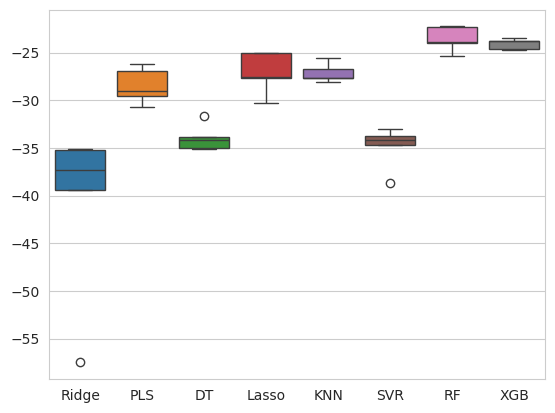

In [32]:
sns.boxplot(results)